# SuperVoice dVAE evaluation
This notebook provides tools for dVAE evaluation

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display
import fsspec
import os

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Local
from vocoder.model import Generator
from dvae.model import DiscreteVAE
from utils.misc import plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from train_config import config

### Environment

In [2]:
# Parameters
device = torch.device('cuda:0')
checkpoint = "./checkpoints/dvae_dvae_3gelu.pt"
checkpoint_vocoder = "./checkpoints/vocoder_sr_24khz.pt"

# Device and Model
dvae = DiscreteVAE(
    # Base mel spec parameters
    positional_dims=1,
    channels=config.audio.num_mels,

    # Number of possible tokens
    num_tokens=config.dvae.tokens,

    # Architecture
    codebook_dim=config.dvae.codebook_dim,
    hidden_dim=config.dvae.hidden_dim,
    num_resnet_blocks=config.dvae.num_resnet_blocks,
    kernel_size=config.dvae.kernel_size,
    num_layers=config.dvae.num_layers,
    use_transposed_convs=False,
).to(device)
generator = Generator(config).to(device)

# Load checkpoint
data = torch.load(checkpoint)
dvae.load_state_dict(data['dvae'])
data = torch.load(checkpoint_vocoder)
generator.load_state_dict(data['generator'])

# Switch to eval
dvae.eval()
generator.eval()
generator.remove_weight_norm()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


torch.Size([1, 170]) torch.Size([80, 677]) torch.Size([80, 680])
tensor([[380, 440, 250, 213,  18, 333, 418, 418, 425, 226, 383, 408, 451, 157,
         190, 109,   2, 112,  28, 349, 157, 127, 359, 211, 247, 325, 398, 332,
         377, 264,  31,  31,  31, 421, 332, 334, 135, 249, 408, 276, 328, 458,
           4,  69, 394, 305, 211, 423, 380, 177, 200, 398, 418, 442, 376, 281,
         299,  52, 408, 371, 254, 428, 428, 342, 387, 415,  30, 261,  21, 212,
         232, 232, 223, 316, 355, 430, 358, 450, 364, 226, 222, 280, 408, 377,
         124, 235, 227, 330, 183, 212, 426, 159, 374, 115,  21, 352,  96, 212,
         183,  85,  80, 385, 149, 183, 283, 198,  50, 230, 436, 399, 198, 375,
          85, 367, 317, 408, 165,  96,  31,  31, 177, 184, 223, 382, 307, 388,
         232, 362, 449, 375, 111, 366, 439, 297, 369, 246, 457, 401, 301, 267,
          31,   6,   6,  98, 223, 200, 280, 347,  96, 146, 425, 186,  57, 355,
         369, 218, 457, 413, 386, 301, 410, 457, 160, 155, 446, 37

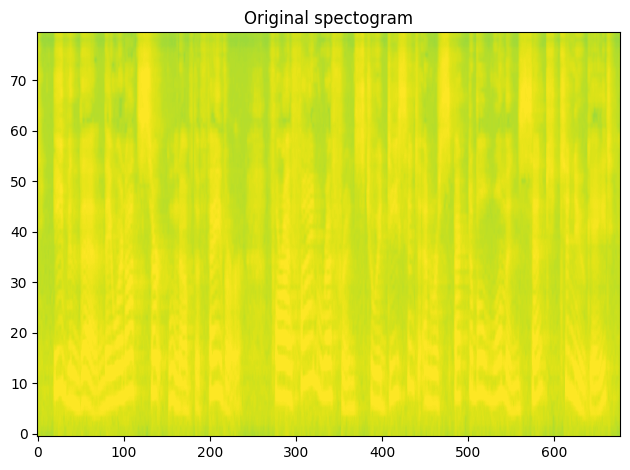

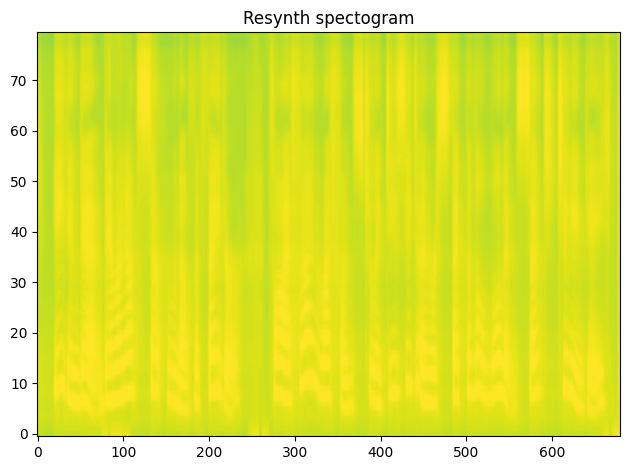

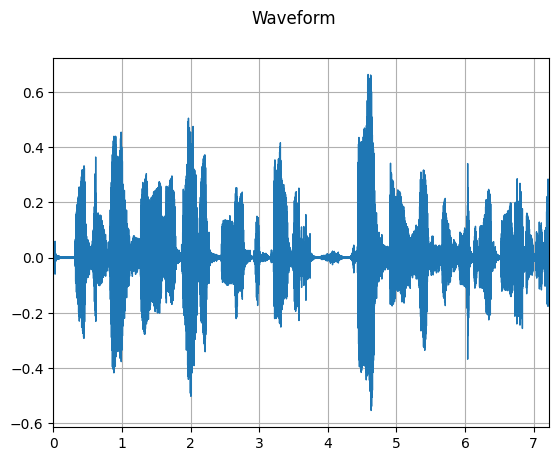

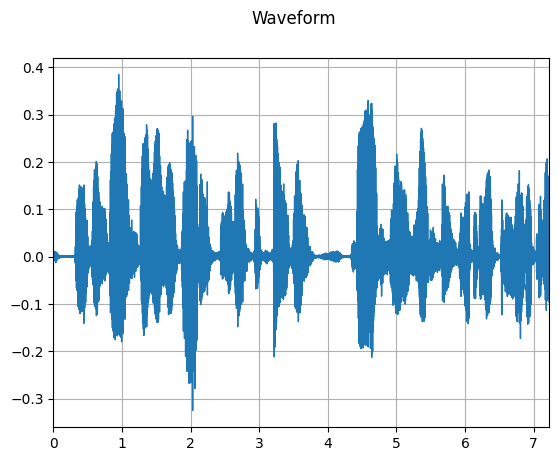

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", config.audio.sample_rate)
else:
    test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ005-0005.wav", config.audio.sample_rate)
spec = spectogram(test, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Generate
codes = dvae.get_codebook_indices(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec, codes_spec_2 = dvae.infer(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec = codes_spec * config.dvae.log_mel_multiplier
resynth = generator(codes_spec).detach().cpu().squeeze(0)
codes_spec = codes_spec.detach().cpu().squeeze(0)

print(codes.shape, spec.shape, codes_spec.shape)

print(codes)
print(spec)
print(codes_spec)
print(codes_spec_2)

# resynth = dvae generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
# resynth_spec = spectogram(resynth, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.audio.sample_rate))
plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
display(Audio(data=test, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Manual Synthesizing
This section allows you to use tokens that want to decode the sound

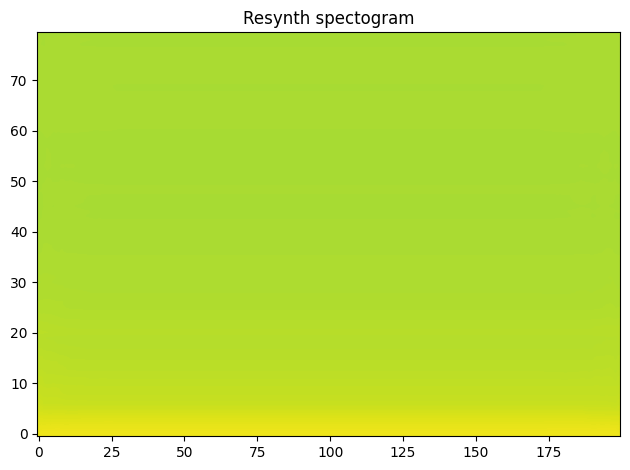

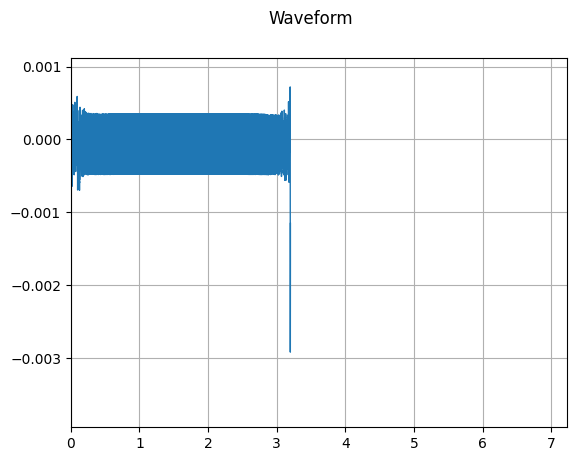

In [5]:
# Generate
codes = [60] * 50
codes_spec, _ = dvae.decode(torch.LongTensor(codes,).unsqueeze(0).to(device))
codes_spec = codes_spec * config.dvae.log_mel_multiplier
resynth = generator(codes_spec).detach().cpu().squeeze(0)
codes_spec = codes_spec.detach().cpu().squeeze(0)

# Source
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))